In [1]:
import sys
sys.path.append('../src/')
import time
import os
import copy

import numpy as np
from scipy.linalg import subspace_angles
import tensorly as tn
import matplotlib.pyplot as plt
import matlab.engine

from loewnerize_acts import loewnerize_acts
import ll1_tools

In [2]:
targets_path = '../data/LenetLinear/activations/test/targets.npy'
targets = np.load(targets_path)

inputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.linear.npy'
inputs_raw = np.load(inputs_path)
print('Inputs shape')
print(inputs_raw.shape)

outputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.rat.npy'
outputs_raw = np.load(outputs_path)
print('Outputs shape')
print(outputs_raw.shape)

# tensorlab_path = '~/ware/matlab_tools/tensorlab'
tensorlab_path = '~/tools/matlab_tools/Tensorlab'

Inputs shape
(39, 256, 10)
Outputs shape
(39, 256, 10)


## split raw data into two data sets


In [3]:
inputs_1 = inputs_raw[:19,:,:]
outputs_1 = outputs_raw[:19,:,:]
print(inputs_1.shape)
print(outputs_1.shape)
inputs_2 = inputs_raw[19:38,:,:]
outputs_2 = outputs_raw[19:38,:,:]
print(inputs_2.shape)
print(outputs_2.shape)

print(targets.shape)
targets_1 = targets[:4864]
targets_2 = targets[4865:9729]
print(targets_1.shape)
print(targets_2.shape)

# flatten into matrices, in terms of BSS (X = MS), these are 'X'
X_1 = outputs_1.reshape(-1, outputs_1.shape[-1])
X_2 = outputs_2.reshape(-1, outputs_2.shape[-1])
print(X_1.shape)
print(X_2.shape)

# build loewnerized tensors
lwn_tensors_1 = loewnerize_acts(inputs_1, outputs_1, targets_1, tensorlab_path)
lwn_tensors_2 = loewnerize_acts(inputs_2, outputs_2, targets_2, tensorlab_path)

(19, 256, 10)
(19, 256, 10)
(19, 256, 10)
(19, 256, 10)
(9984,)
(4864,)
(4864,)
(4864, 10)
(4864, 10)


In [5]:
eng = matlab.engine.start_matlab()
s = eng.genpath(tensorlab_path)
eng.addpath(s, nargout=0)

num_terms = 25
rat_deg = 3

L = rat_deg * np.ones(num_terms)
super_lwn_1 = lwn_tensors_1[0]
super_lwn_2 = lwn_tensors_2[0]
for i in range(9):
    super_lwn_1 = np.dstack((super_lwn_1, lwn_tensors_1[i+1]))
    super_lwn_2 = np.dstack((super_lwn_2, lwn_tensors_2[i+1]))

tic = time.perf_counter()
all_U_1, all_out_1 = eng.ll1(super_lwn_1, L, nargout=2)
all_U_2, all_out_2 = eng.ll1(super_lwn_2, L, nargout=2)

toc = time.perf_counter()
print(toc-tic)

> In ll1_core/state (line 238)
In ll1_core (line 191)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll

In [6]:
res_1 = 1 - eng.frobll1res(super_lwn_1,all_U_1) / eng.frob(super_lwn_1)
print(f"Residual_1: {res_1}")
res_2 = 1 - eng.frobll1res(super_lwn_2,all_U_2) / eng.frob(super_lwn_2)
print(f"Residual_2: {res_2}")

print(len(all_U_1))
print(np.asarray(all_U_1[0][0]).shape)

Residual_1: 0.9999987479141099
Residual_2: 0.9999981295710872
25
(5, 3)


In [7]:
def recover_sources(obs, mix):
    sources = np.matmul(mix.T, obs)  # technically should be conjugate transpose (which is transpose for real-valued data)
    return sources

In [8]:
U_1 = ll1_tools.pack_ll1(all_U_1)
U_2 = ll1_tools.pack_ll1(all_U_2)

In [9]:
#Recover sources
S_1 = recover_sources(X_1, U_1[2])
S_2 = recover_sources(X_2, U_2[2])
print(f"Obvs: {X_1.shape}, Srcs: {S_1.shape}")
print(f"Obvs: {X_2.shape}, Srcs: {S_2.shape}")

Obvs: (4864, 10), Srcs: (25, 10)
Obvs: (4864, 10), Srcs: (25, 10)


In [11]:
col_1,sv_1,row_1 = np.linalg.svd(S_1)
col_2,sv_2,row_2 = np.linalg.svd(S_2)
print(f"Col_1: {col_1.shape}, Col_2: {col_2.shape}")
angles = np.rad2deg(col_1, col_2)
print(angles.shape)
print(angles[0][:])

Col_1: (25, 25), Col_2: (25, 25)
(25, 25)
[ -4.6324293   15.34574204  -3.23659198  11.00125725 -13.35658343
  -3.44115238 -17.22358454 -14.36774152  -3.53421612  46.7195774
  -0.12048766  -0.12048766   0.69282985   0.69282985   0.69282985
   0.73665058  -0.05699477   1.15398251  -0.66107256  -0.24412421
  -0.26828028   0.62016829   0.69872674   0.69872674   0.73645593]


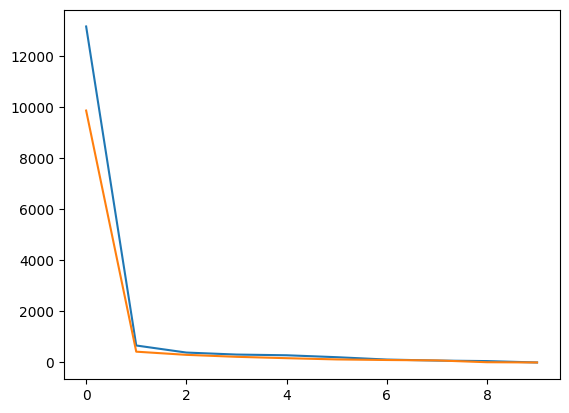

In [13]:
plt.plot(sv_1)
plt.plot(sv_2)


In [16]:
ang = eng.subspace(S_1, S_2)
print(ang)
ang_col = eng.subspace(col_1, col_2)
print(ang_col)

1.5885281174482214e-14
1.2557465160251204e-15
